# Gender classification

In [69]:
import os
import pandas as pd
import librosa 
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal import ShortTimeFFT
from scipy.signal import windows

In [70]:
image_path = '../doc/images/'

## Functions

In [71]:
import pandas as pd

def table_to_latex(df: pd.DataFrame, filename: str) -> None:
    """
    Exports a pandas DataFrame to a LaTeX file.

    Parameters:
    - df (pd.DataFrame): The DataFrame to export.
    - filename (str): The name of the file (without extension) where the LaTeX table will be saved.
    """
    # Generate LaTeX code from the DataFrame
    latex_code = df.to_latex(index=False, escape=True)
    
    # Use an f-string to dynamically insert the filename
    with open(f"../doc/tables/{filename}.tex", "w") as f:
        f.write(latex_code)


## list some file directories

In [72]:

# Specify the directory
directory_clips = 'data/cv-corpus-16.1-delta-2023-12-06/en/clips'
directory_labels = 'data/cv-corpus-16.1-delta-2023-12-06/en/'

reported = 'data/cv-corpus-16.1-delta-2023-12-06/en/validated.tsv'

# List all files and directories in the specified directory
files = os.listdir(directory_clips)
labels = os.listdir(directory_labels)

# Print filenames
print(files[0:10])
print(labels[0:10])



['common_voice_en_39124688.mp3', 'common_voice_en_38492555.mp3', 'common_voice_en_39014458.mp3', 'common_voice_en_38627321.mp3', 'common_voice_en_39015882.mp3', 'common_voice_en_38559189.mp3', 'common_voice_en_39094136.mp3', 'common_voice_en_39583678.mp3', 'common_voice_en_38968922.mp3', 'common_voice_en_38743424.mp3']
['reported.tsv', 'clips', 'invalidated.tsv', 'clip_durations.tsv', 'validated.tsv', 'other.tsv']


### Inspect Labels

In [73]:
# load the data labels
df = pd.read_csv(reported, sep='\t', header=0,)

# drop unecesary columns
df = df. drop(columns=['client_id','up_votes', 'down_votes', 'accents', 'locale', 'segment', 'variant'])

# drop rows with missing values
df = df.dropna(subset=['gender'])

print(df.shape)
head = df.head()


table_to_latex(head, 'features')

head

(3076, 4)


,path,sentence,age,gender
5,common_voice_en_38570599.mp3,Flatow was given a co-star credit.,twenties,male
8,common_voice_en_39572424.mp3,A timetable for the move was not specified.,fifties,male
13,common_voice_en_39548774.mp3,Where can i find the supreme leader?,teens,female
15,common_voice_en_38594742.mp3,"Down jumped the driver, and out got Mr. Pickwick.",twenties,male
22,common_voice_en_38514380.mp3,He was the original sponsor of legislation cre...,sixties,male


## Data Import

In [74]:
# Update paths with the base directory path
paths = [os.path.join(directory_clips, path) for path in df['path'].values]

# Load the audio file (example: first file in paths list)
audio_data, sample_rate = librosa.load(paths[1], sr=None)  # `sr=None` keeps the original sample rate

# Display information
print("Audio Data Shape:", audio_data.shape)
print("Sample Rate:", sample_rate)

Audio(audio_data, rate=sample_rate)


Audio Data Shape: (182016,)
Sample Rate: 32000


## Feature Extraction

### Waveform

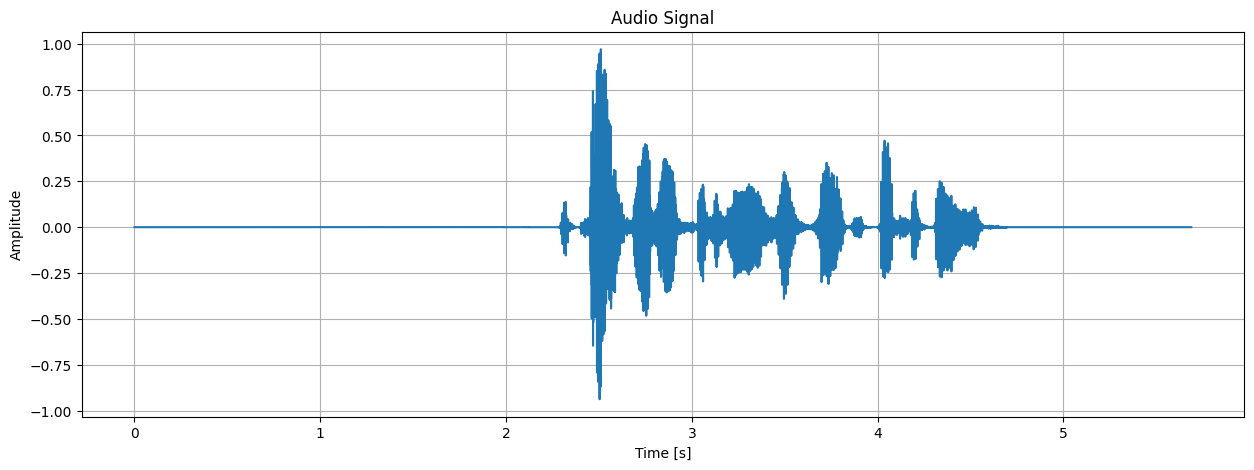

In [75]:
t = np.linspace(0, len(audio_data)/sample_rate, len(audio_data))
plt.figure(figsize=(15, 5))
plt.plot(t, audio_data)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Audio Signal')
plt.grid()
plt.show()


### Spectrogram

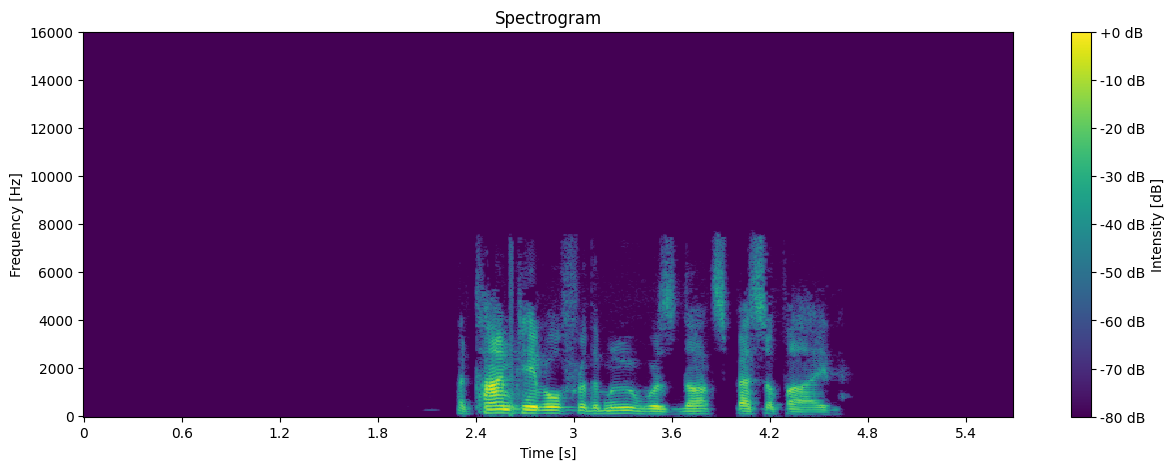

In [76]:
# Set parameters for the STFT
N = 1024  # FFT window size
hop_length = 256  # Overlap between frames, adjust as needed

# Calculate STFT (Short-Time Fourier Transform)
Sx = librosa.stft(audio_data, n_fft=N, hop_length=hop_length, window='hann')

# Convert amplitude spectrogram to dB scale (log scale for intensity)
Sx_dB = librosa.amplitude_to_db(abs(Sx), ref=np.max)



# Plot the spectrogram
title = 'Spectrogram'
fig, ax = plt.subplots(figsize=(15, 5))
img = librosa.display.specshow(Sx_dB, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='hz', cmap='viridis')
ax.set_title(title)
fig.colorbar(img, ax=ax, format="%+2.0f dB", label='Intensity [dB]')
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
fig.savefig(image_path + title + '.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

### Melspectrogram

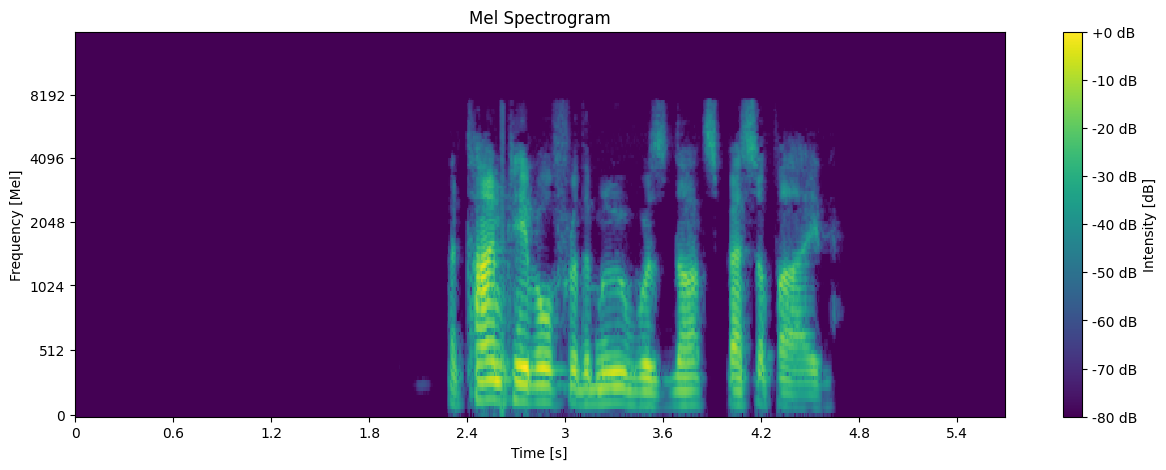

In [77]:
# melspectrogram
Sx_mel = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_fft=N, hop_length=hop_length)

# Convert amplitude spectrogram to dB scale (log scale for intensity)
Sx_mel_dB = librosa.power_to_db(Sx_mel, ref=np.max)

# Plot the mel spectrogram
title = 'Mel Spectrogram'
fig, ax = plt.subplots(figsize=(15, 5))
img = librosa.display.specshow(Sx_mel_dB, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis')
ax.set_title(title)
fig.colorbar(img, ax=ax, format="%+2.0f dB", label='Intensity [dB]')
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
fig.savefig(image_path + title + '.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()


## Feature extraction